In [21]:
import torch.multiprocessing as mp

# Set the multiprocessing start method to 'spawn'
mp.set_start_method('spawn', force=True)


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import requests
from io import BytesIO
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator


In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
device

device(type='cuda')

In [25]:
# def imgshow(number , title=None , size=5):

#     root = "/kaggle/input/guns-object-detection/"
#     image = cv2.imread(root+"Images/" + str(number) + ".jpeg")

#     file = open(root+"Labels/" + str(number) +".txt" , "r")
#     txt_data = file.readlines()
#     file.close()

#     for i in range(0,int(txt_data[0])):
#         indices = [int(x) for x in txt_data[i+1].split()]
#         start_point = (indices[0] , indices[1])
#         end_point = (indices[2] , indices[3])

#         cv2.rectangle(image , start_point , end_point , (0,0,255) , 2)

#     aspect_ratio = image.shape[0] / image.shape[1]

#     plt.figure(figsize=(size+aspect_ratio,size))

#     plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
#     plt.title(title+txt_data[0])
#     plt.show()
    

In [26]:
# imgshow(1, title="Gun Detection")


In [27]:
import cv2
import matplotlib.pyplot as plt

def imgshow(number, title="Image", size=6):
    # Define image and label paths
    root = "/kaggle/input/guns-object-detection/"
    img_path = f"{root}Images/{number}.jpeg"
    label_path = f"{root}Labels/{number}.txt"

    # Load the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found: {img_path}")
        return

    # Read label file and draw bounding boxes
    try:
        with open(label_path, "r") as file:
            lines = file.readlines()[1:]  # Skip the first line if it's box count
            for line in lines:
                x1, y1, x2, y2 = map(int, line.strip().split())
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    except FileNotFoundError:
        print(f"Label file not found: {label_path}")
        return

    # Show the image using matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size, size))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()


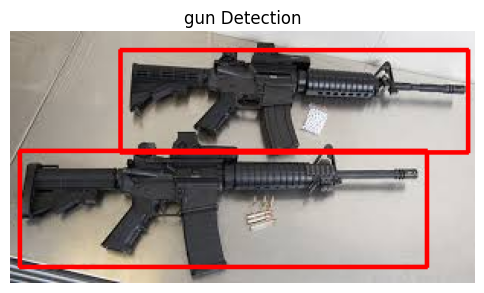

In [28]:
imgshow(119, title="gun Detection")


In [29]:
class GunDataset(Dataset):
    def __init__(self, root, device='cpu'):
        self.image_dir = os.path.join(root, "Images")
        self.label_dir = os.path.join(root, "Labels")
        self.image_files = sorted(os.listdir(self.image_dir))
        self.device = device  # Keep this for compatibility, but don't use it here

    def __getitem__(self, idx):
        # Load image
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        image = torch.tensor(image).permute(2, 0, 1)  # Do NOT move to device here

        # Load corresponding label
        label_file = img_file.replace(".jpeg", ".txt")
        label_path = os.path.join(self.label_dir, label_file)

        with open(label_path, "r") as f:
            lines = f.readlines()[1:]  # Skip first line (box count)
            boxes = [list(map(int, line.strip().split())) for line in lines]

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        area = ((boxes_tensor[:, 2] - boxes_tensor[:, 0]) *
                (boxes_tensor[:, 3] - boxes_tensor[:, 1]))
        target = {
            "boxes": boxes_tensor,
            "labels": torch.ones((len(boxes),), dtype=torch.int64),
            "area": area,
            "image_id": torch.tensor([idx])
        }

        return image, target

    def __len__(self):
        return len(self.image_files)


In [30]:
# import torch
# import torchvision
# from torchvision.models.detection import fasterrcnn_resnet50_fpn
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from tqdm import tqdm


# class Model:
#     def __init__(self, num_classes, device='cuda'):
#         self.num_classes = num_classes
#         self.device = device
#         self.model = self.create_model()
#     def create_model(self):
#         model = fasterrcnn_resnet50_fpn(pretrained=True)
#         # Get the number of input features of the box predictor
#         in_features = model.roi_heads.box_predictor.cls_score.in_features
        
#         # Replace the box predictor with a new one that matches our number of classes
#         model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        
#         return model.to(self.device)
        
#     def compile(self, optimizer, lr_scheduler=None):
#         self.optimizer = optimizer
#         #self.lr_scheduler = lr_scheduler  # Optional learning rate scheduler

#     def train(self, train_data, val_data, num_epochs):
#          self.model.train()
         
#          for epoch in range(num_epochs):
#              train_loss = 0
#              for images, targets in tqdm(train_data, desc=f"Epoch {epoch+1}/{num_epochs}"):
#                  images = [image.to(self.device) for image in images]
#                  targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
#                  # Zero the gradients
#                  self.optimizer.zero_grad()
#                  # Forward pass
#                  loss_dict = self.model(images, targets)
#                   # Total loss
#                  losses = sum(loss for loss in loss_dict.values())
#                  # Backward pass
#                  losses.backward()
                 
#                  # Update the weights
#                  self.optimizer.step()
#                  train_loss += losses.item()
#                  # Print training loss for the epoch
#              print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

                 
             






In [31]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm


class Model:
    def __init__(self, num_classes, device='cuda'):
        self.num_classes = num_classes  # num_classes = number of classes, including background
        self.device = device
        self.model = self.create_model()

    def create_model(self):
        # Load the Faster R-CNN model with a ResNet50 backbone and FPN
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        # Get the number of input features of the box predictor
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # Replace the box predictor with a new one that matches our number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)

        return model.to(self.device)

    def compile(self, optimizer, lr_scheduler=None):
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler  # Optional learning rate scheduler

    def train(self, train_data, val_data, num_epochs):
        self.model.train()

        for epoch in range(num_epochs):
            train_loss = 0
            for images, targets in tqdm(train_data, desc=f"Epoch {epoch+1}/{num_epochs}"):
                # Move images and targets to the correct device
                images = [image.to(self.device) for image in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass
                loss_dict = self.model(images, targets)

                # Total loss
                losses = sum(loss for loss in loss_dict.values())

                # Backward pass
                losses.backward()

                # Update the weights
                self.optimizer.step()

                train_loss += losses.item()

            # Print training loss for the epoch
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

In [33]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import random
import os
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(seed)

set_seed()

# Initialize the model wrapper with 2 classes (background + 1 object class)
rcnn_model = Model(num_classes=2, device=device)
model = rcnn_model.model

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set number of training epochs
num_epochs = 30

# Compile the model with optimizer (optionally add scheduler)
rcnn_model.compile(optimizer)

# Collate function for variable-sized targets
def collate_fn(batch):
    return tuple(zip(*batch))

# Load the dataset
dataset = GunDataset("/kaggle/input/guns-object-detection/", device=device)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
batch_size = 4  # Increased batch size (adjust based on GPU memory)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Use >0 if supported by the environment
    collate_fn=collate_fn,
    pin_memory=(device.type == 'cuda')
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=(device.type == 'cuda')
)

# Now train the model
rcnn_model.train(train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/30: 100%|██████████| 67/67 [00:50<00:00,  1.34it/s]


Epoch 1/30, Train Loss: 16.9942


Epoch 2/30: 100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


Epoch 2/30, Train Loss: 12.6367


Epoch 3/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 3/30, Train Loss: 10.0267


Epoch 4/30: 100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


Epoch 4/30, Train Loss: 8.5834


Epoch 5/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 5/30, Train Loss: 7.6281


Epoch 6/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 6/30, Train Loss: 6.5811


Epoch 7/30: 100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


Epoch 7/30, Train Loss: 5.7530


Epoch 8/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 8/30, Train Loss: 5.3313


Epoch 9/30: 100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


Epoch 9/30, Train Loss: 4.7198


Epoch 10/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 10/30, Train Loss: 4.6587


Epoch 11/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 11/30, Train Loss: 4.0433


Epoch 12/30: 100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


Epoch 12/30, Train Loss: 3.8116


Epoch 13/30: 100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


Epoch 13/30, Train Loss: 3.6357


Epoch 14/30: 100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


Epoch 14/30, Train Loss: 3.2178


Epoch 15/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 15/30, Train Loss: 3.5804


Epoch 16/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 16/30, Train Loss: 3.1133


Epoch 17/30: 100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


Epoch 17/30, Train Loss: 3.0636


Epoch 18/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 18/30, Train Loss: 2.8262


Epoch 19/30: 100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


Epoch 19/30, Train Loss: 2.8476


Epoch 20/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 20/30, Train Loss: 2.8159


Epoch 21/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 21/30, Train Loss: 2.7185


Epoch 22/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Epoch 22/30, Train Loss: 2.7020


Epoch 23/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 23/30, Train Loss: 2.5879


Epoch 24/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 24/30, Train Loss: 2.5585


Epoch 25/30: 100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


Epoch 25/30, Train Loss: 2.5304


Epoch 26/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 26/30, Train Loss: 2.4471


Epoch 27/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 27/30, Train Loss: 2.4819


Epoch 28/30: 100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


Epoch 28/30, Train Loss: 2.2792


Epoch 29/30: 100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


Epoch 29/30, Train Loss: 2.3285


Epoch 30/30: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]

Epoch 30/30, Train Loss: 2.2007


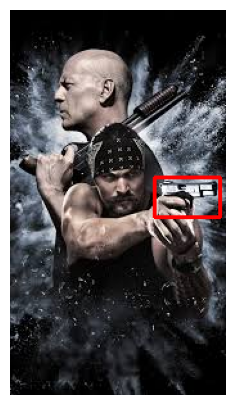

In [34]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import random

# Torch to PIL for plotting
def torch_to_pil(img_tensor):
    transform = T.ToPILImage()
    return transform(img_tensor.cpu()).convert("RGB")

# Plotting function for image + bounding boxes
def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0] / img_cv.shape[1]
    plt.figure(figsize=(size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Apply NMS
def apply_nms(prediction, iou_threshold=0.5):
    keep = torchvision.ops.nms(prediction["boxes"], prediction["scores"], iou_threshold)

    filtered_prediction = {
        "boxes": prediction["boxes"][keep],
        "scores": prediction["scores"][keep],
        "labels": prediction["labels"][keep],
    }
    return filtered_prediction

# Test function
def test(model, dataset, number=None, iou_threshold=0.5, score_threshold=0.5, plot=True):
    model.eval()

    if number is None:
        number = random.randint(0, len(dataset) - 1)

    # Get image and target
    img, target = dataset[number]
    img = img.to(device)

    # Make prediction
    with torch.no_grad():
        prediction = model([img])[0]

    # Apply NMS
    prediction = {k: v.cpu() for k, v in prediction.items()}
    prediction = apply_nms(prediction, iou_threshold=iou_threshold)

    # Filter out low score boxes
    score_mask = prediction["scores"] > score_threshold
    prediction = {
        k: v[score_mask] for k, v in prediction.items()
    }

    if plot:
        pil_img = torch_to_pil(img)
        plot_img_bbox(pil_img, prediction)

    return prediction, target, img

# Example usage
nms_prediction, target, img = test(model, dataset, number=1, iou_threshold=0.7)


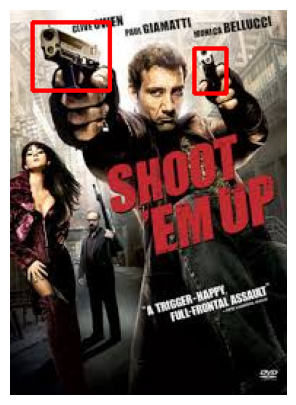

In [35]:
nms_prediction, target, img = test(model, dataset, number=10, iou_threshold=0.7)

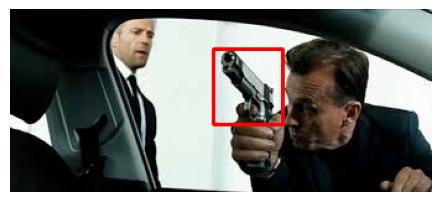

In [36]:
nms_prediction, target, img = test(model, dataset, number=110, iou_threshold=0.7)